In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from tensorflow.keras.models import load_model

In [9]:
data = pd.read_csv("data_cleaned.csv")

urls = data['thumbnail_url'].tolist()

os.makedirs("downloaded_images", exist_ok=True)

def download_image(url, save_path):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        response = requests.head(url, headers=headers, timeout=5)
        if response.status_code != 200:
            print(f"Skipping invalid URL: {url}")
            return False

        response = requests.get(url, headers=headers, timeout=10)
        img = Image.open(BytesIO(response.content))
        img.save(save_path)
        print(f"Downloaded: {url}")
        return True
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return False
downloaded_count = 0
for i, url in enumerate(urls):
    if downloaded_count >= 11039: 

    save_path = os.path.join("downloaded_images", f"image_{i+1}.jpg")
    success = download_image(url, save_path)
    if success:
        downloaded_count += 1

print(f"Finished downloading {downloaded_count} images.")


Skipping invalid URL: https://a0.muscache.com/im/pictures/81318153/ab4f4f30_original.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/aa00250e-076c-42dd-8463-4621bc0a37a0.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/e0c9b2f9-a339-4b26-812a-9c0b1c34fecc.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/8ed8be1f-dfad-4b7a-9254-49812c3a82f4.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/03a6b9ca-fcb2-40e3-95af-d20fb9bb15c5.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/0dce5c5f-b049-403d-826f-bb767cf93606.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/a5b0ac0a-fe9b-4d61-9685-e9b11538249c.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/fa628319-efc5-4790-bb84-3aac23b73551.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/48960014/d876fbb2_original.jpg?aki_policy=small
Downloaded: https://a0.muscache.com/im/pictures/39822494

In [1]:
def load_image(image_path, target_size=(128, 128)):
    try:
        img = Image.open(image_path).convert("RGB")
        img = img.resize(target_size)
        img_array = np.array(img) / 255.0
        return img_array
    except Exception as e:
        print(f"Failed to load image {image_path}: {e}")
        return None


# download pictures
def download_user_image(url, save_path="user_uploaded_image.jpg"):
    response = requests.get(url)
    response.raise_for_status()
    img = Image.open(BytesIO(response.content))
    img.save(save_path)
    return save_path


# deal with pictures
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    filenames = []
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            img = Image.open(file_path).convert("RGB")
            img = img.resize(target_size)
            img_array = np.array(img) / 255.0
            images.append(img_array)
            filenames.append(filename)
        except Exception as e:
            print(f"Failed to process image {filename}: {e}")
    return np.array(images), filenames

# ground_truth_labels function to train model
def create_ground_truth_labels_normalized(user_city, user_combined_features, database_data, database_combined_features, similarity_threshold=0.7):
    """
    Normalize ground truth labels
    """
    minmax_scaler = MinMaxScaler()
    combined_features_normalized = minmax_scaler.fit_transform(database_combined_features)
    user_feature_normalized = minmax_scaler.transform(user_combined_features.reshape(1, -1))

    similarities = cosine_similarity(user_feature_normalized, combined_features_normalized).flatten()
    print(f"Normalized Similarity distribution: {np.percentile(similarities, [0, 25, 50, 75, 100])}")

    city_mask = database_data['city'].fillna('').str.contains(user_city, case=False).values
    labels = np.where((city_mask) & (similarities >= similarity_threshold), 1, 0)
    return labels


In [ ]:
data = pd.read_csv("data_cleaned.csv")

# Preprocess numerical features
numerical_columns = ['bedrooms', 'beds']
for column in numerical_columns:
    data[column].fillna(data[column].mode()[0], inplace=True)

X_images, image_filenames = load_images_from_folder("downloaded_images")
print(f"Loaded {len(X_images)} images from folder.")

if len(X_images) < len(data):
    print(f"Warning: Only {len(X_images)} images found for {len(data)} records.")
    data = data.iloc[:len(X_images)].reset_index(drop=True)
elif len(X_images) > len(data):
    print(f"Warning: More images ({len(X_images)}) than records ({len(data)}).")
    X_images = X_images[:len(data)]
assert len(X_images) == len(data), "Mismatch between image data and tabular data!"
print("Image data and tabular data are aligned.")


# split the dataset
train_data, database_data = train_test_split(data, test_size=1/3, random_state=42)
train_images = X_images[:len(train_data)]
database_images = X_images[len(train_data):]

# extract information
base_resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
train_image_features = base_resnet_model.predict(train_images.astype("float32"))
database_image_features = base_resnet_model.predict(database_images.astype("float32"))

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MultiLabelBinarizer

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()
mlb = MultiLabelBinarizer()

categorical_features = ['property_type']
numerical_columns = ['bedrooms', 'beds']

train_combined_features = np.hstack([
    train_image_features,
    encoder.fit_transform(train_data[categorical_features]),
    scaler.fit_transform(train_data[numerical_columns]),
    mlb.fit_transform(train_data['amenities'])
])

database_combined_features = np.hstack([
    database_image_features,
    encoder.transform(database_data[categorical_features]),
    scaler.transform(database_data[numerical_columns]),
    mlb.transform(database_data['amenities'])
])

user_city = "LA"
user_image_url = "https://a0.muscache.com/im/pictures/111395989/6db32dc2_original.jpg?aki_policy=small"
user_image_path = download_user_image(user_image_url)  # 下载图片

user_image = load_image(user_image_path).reshape(1, 128, 128, 3)
user_image_feature = base_resnet_model.predict(user_image.astype("float32"))


user_tabular_features = np.hstack([
    encoder.transform([['House']]),
    scaler.transform([[3, 2]]),
    mlb.transform([{'TV', 'Internet'}])
])
user_combined_features = np.hstack([user_image_feature.flatten(), user_tabular_features.flatten()])

ground_truth_labels = create_ground_truth_labels_normalized(
    user_city=user_city,
    user_combined_features=user_combined_features,
    database_data=database_data,
    database_combined_features=database_combined_features,
    similarity_threshold=0.7
)

X_train, X_val, y_train, y_val = train_test_split(database_images, ground_truth_labels, test_size=0.2, random_state=42)

from tensorflow.keras.applications import ResNet101

base_model = ResNet101(weights='imagenet', include_top=False,input_shape=(128, 128, 3))
for layer in base_model.layers[:140]:
    layer.trainable = False

from tensorflow.keras.regularizers import l2

x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu',kernel_regularizer=l2(0.01))(x) 
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

fine_tuned_model = Model(inputs=base_model.input, outputs=output)
fine_tuned_model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15)
train_generator = datagen.flow(X_train, y_train, batch_size=32)
val_generator = datagen.flow(X_val, y_val, batch_size=32)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

history = fine_tuned_model.fit(train_generator, validation_data=val_generator, epochs=20)
fine_tuned_model.save("fine_tuned_resnet_model.h5")

NameError: name 'pd' is not defined

In [18]:
# fine-tuned model
fine_tuned_model = load_model("fine_tuned_resnet_model.h5")

def extract_image_features_with_fine_tuned_model(images):
    return fine_tuned_model.predict(images)

def recommend_similar_listings(user_image_path, database_data, database_combined_features, user_city):
    user_image = load_image(user_image_path).reshape(1, 128, 128, 3)
    user_image_feature = extract_image_features_with_fine_tuned_model(user_image.astype("float32"))

    if 'categorical_features' in globals() and 'numerical_columns' in globals() and 'mlb' in globals():
        default_property_type = 'House'
        default_bedrooms = 3
        default_beds = 2
        default_amenities = {'TV', 'Internet'}

        user_tabular_features = np.hstack([
            encoder.transform([[default_property_type]]),
            scaler.transform([[default_bedrooms, default_beds]]),
            mlb.transform([default_amenities])
        ])

    
        user_combined_features = np.hstack([user_image_feature.flatten(), user_tabular_features.flatten()])
    else:
        user_combined_features = user_image_feature.flatten()

    minmax_scaler = MinMaxScaler()
    combined_features_normalized = minmax_scaler.fit_transform(database_combined_features)
    user_feature_normalized = minmax_scaler.transform(user_combined_features.reshape(1, -1))

    similarity = cosine_similarity(user_feature_normalized, combined_features_normalized).flatten()
    similarity = np.clip(similarity, 0, 1)

    print(f"Normalized Similarity distribution: {np.percentile(similarity, [0, 25, 50, 75, 100])}")

    top_indices = np.argsort(similarity)[::-1]

    # recommendation results
    recommendations = []
    for idx in top_indices:
        listing = database_data.iloc[idx]
        if listing['city'].lower() == user_city.lower():  
            recommendations.append({
                'listing_id': listing['id'],
                'similarity': similarity[idx],
                'price':listing['log_price'],
                'property_type': listing['property_type'],
                'bedrooms': listing['bedrooms'],
                'amenities': listing['amenities'],
                'review_score':listing['review_scores_rating'],
                'image': database_images[idx]
            })
        if len(recommendations) >= 5:  
            break
    return recommendations

def filter_by_city(city, database_data, database_images):
    city_mask = database_data['city'].str.contains(city, case=False, na=False)
    filtered_data = database_data[city_mask].reset_index(drop=True)
    filtered_images = database_images[city_mask.values]

    print(f"Filtered data size: {len(filtered_data)}, Filtered images size: {len(filtered_images)}")

    return filtered_data, filtered_images



Filtered data size: 1066, Filtered images size: 1066
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Normalized Similarity distribution: [0.         0.00412717 0.00853695 0.09217335 0.59950554]
Listing ID: 1550146, Similarity: 0.60
Price:5.010635294096256, Review_Score: 93.0
Property Type: House, Bedrooms: 2.0, Amenities: {}


c:\Users\13433\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Users\13433\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\13433\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:900: UserWarning: unknown class(es) ['Internet', 'TV'] will be ignored
  warnings.warn(


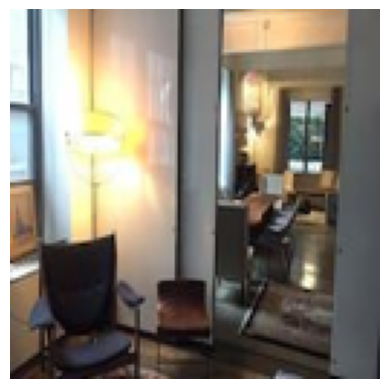

Listing ID: 6887043, Similarity: 0.59
Price:4.8283137373023015, Review_Score: 93.0
Property Type: House, Bedrooms: 1.0, Amenities: {}


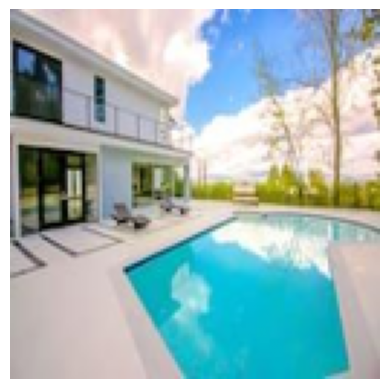

Listing ID: 17419253, Similarity: 0.59
Price:4.59511985013459, Review_Score: nan
Property Type: House, Bedrooms: 1.0, Amenities: {}


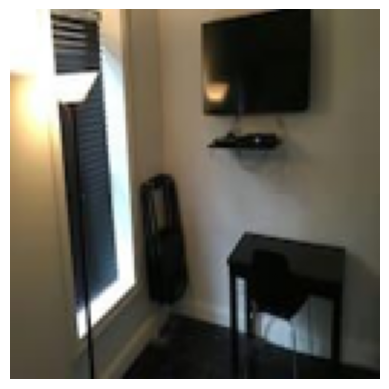

Listing ID: 14105831, Similarity: 0.59
Price:3.1354942159291497, Review_Score: 65.0
Property Type: House, Bedrooms: 1.0, Amenities: {}


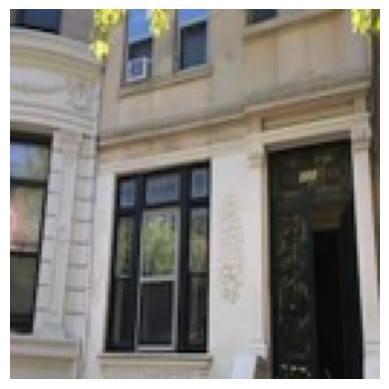

Listing ID: 14821003, Similarity: 0.59
Price:2.8903717578961645, Review_Score: 96.0
Property Type: House, Bedrooms: 1.0, Amenities: {}


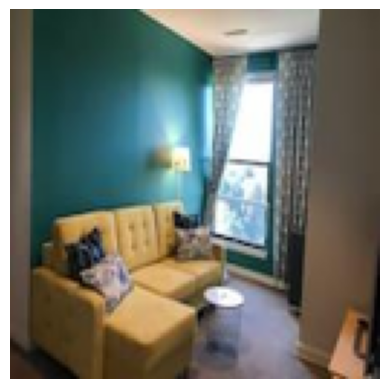

In [23]:
if __name__ == "__main__":
    user_image_url = "https://a0.muscache.com/im/pictures/ee62445f-287a-4286-8e4a-125bf17def49.jpg?aki_policy=small"
    user_image_path = download_user_image(user_image_url)
    user_city = "LA"

    filtered_data, filtered_images = filter_by_city(user_city, database_data, database_images)

    if len(filtered_data) > 0:
        filtered_combined_features = np.hstack([
            extract_image_features_with_fine_tuned_model(filtered_images.astype("float32")),
            encoder.transform(filtered_data[categorical_features]),
            scaler.transform(filtered_data[numerical_columns]),
            mlb.transform(filtered_data['amenities'])
        ])

        recommendations = recommend_similar_listings(user_image_path, filtered_data, filtered_combined_features,user_city)


        for rec in recommendations:
            print(f"Listing ID: {rec['listing_id']}, Similarity: {rec['similarity']:.2f}")
            print(f"Price:{rec['price']}, Review_Score: {rec['review_score']}")
            print(f"Property Type: {rec['property_type']}, Bedrooms: {rec['bedrooms']}, Amenities: {rec['amenities']}")
            plt.imshow(np.clip(rec['image'], 0, 1))
            plt.axis('off')
            plt.show()
    else:
        print(f"No listings found for city '{user_city}'.")

